### Exploration of the Yelp dataset
Data source: https://www.yelp.com/dataset

Dataset documentation: https://www.yelp.com/dataset/documentation/main

Dataset downloaded March 2019

Some notes from the documentation on how the numbers from the different sources will compare:

"The review count represents the total number of reviews a user had posted at the time of data collection, whether Yelp recommended them or not. As for the reviews, only the reviews that were recommended at the time of data collection are included. Also, we only include businesses that have had at least 3 reviews older than 14 days. So the review count number may differ from the number of actual reviews for any given user."

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
from datetime import datetime
import matplotlib as mpl
from scipy.stats import gaussian_kde

In [2]:
mpl.rcParams.update({'font.size': 15})

In [3]:
# Location of the relevant data files
data_dir = 'data/yelp_dataset/'
user_file = data_dir + 'user.json'
business_file = data_dir + 'business.json'
review_file = data_dir + 'review.json'

In [4]:
# First, collect the review counts for each user, so I can examine the distribution
# and later filter for users with high numbers of reviews
user_ids = []
review_counts = []
with open(user_file, 'r', encoding="latin-1") as f:
    for idx, line in enumerate(f):
        user = json.loads(line)
        #if idx % 10000 == 0:
        #    #Make sure I can see it's working
        #    print('Reading user number %8d' %idx)
        user_ids.append(user['user_id'])
        review_counts.append(user['review_count'])
users_df = pd.DataFrame({'user_id': user_ids, 'review_count': review_counts})

In [5]:
# Check and see what I'm demanding of memory
print('Size of user_ids:      %.2f MB' % (sys.getsizeof(user_ids     )/1024/1024))
print('Size of review_counts: %.2f MB' % (sys.getsizeof(review_counts)/1024/1024))
print('Size of users_df:     %.2f MB'  % (sys.getsizeof(users_df     )/1024/1024))
del user_ids
del review_counts

Size of user_ids:      13.29 MB
Size of review_counts: 13.29 MB
Size of users_df:     135.83 MB


In [6]:
# Stats on user review counts
print('Total users:   %8d' %len(users_df.review_count))
print('Total reviews: %8d' %sum(users_df.review_count))
print('Median reviews/user %2.1f' % np.median(users_df.review_count))
print('Mean reviews/usr   %2.1f' % np.mean(users_df.review_count))

n_users = len(users_df)
for threshhold in [100,500,1000]:
    n_superusers = np.sum(users_df.review_count >= threshhold)
    print('%7d users (%0.3f%%) have at least %4d reviews.' %(n_superusers, 100.0 * n_superusers/n_users, threshhold))

Total users:    1637138
Total reviews: 36488037
Median reviews/user 5.0
Mean reviews/usr   22.3
  72950 users (4.456%) have at least  100 reviews.
   6701 users (0.409%) have at least  500 reviews.
   1426 users (0.087%) have at least 1000 reviews.


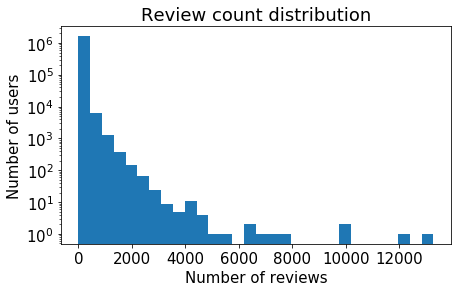

In [7]:
# Visualize distribution of review counts
_ = plt.figure(figsize = (7,4))
_ = plt.hist(users_df.review_count, bins = 30)
_ = plt.yscale('log')
_ = plt.xlabel('Number of reviews')
_ = plt.ylabel('Number of users')
_ = plt.title('Review count distribution')

In [10]:
# Now look at businesses
# I will care about locations and types of businesses
# The closest thing to business types in this dataset is "categories", of which there may be more than one per business
business_ids    = []
names           = []
cities          = []
latitudes       = []
longitudes      = []
categoriess     = []
categoriess_str = []
n_categoriess   = []
category_counts = defaultdict(int)
with open(business_file, 'r', encoding="latin-1") as f:
    for idx, line in enumerate(f):
        business = json.loads(line)
        #if idx % 10000 == 0:
        #    #Make sure I can see it's working
        #    print('Reading business number %8d' %idx)
        business_ids.append(business['business_id'])
        names.append(business['name'])
        cities.append(business['city'])
        latitudes.append(business['latitude'])
        longitudes.append(business['longitude'])
        # Count frequency of category tags
        if business['categories'] is not None:
            # Documentation as of 2019-11-05 says that "categories" is an array of strings,
            # But at least in the version I downloaded, it's a string with categories separated by ', '
            category_str = business['categories']
            categories = category_str.split(', ')
            categoriess.append(categories)
            categoriess_str.append(category_str)
            n_categoriess.append(len(categories))
            for category in categories:
                category_counts[category] += 1
        else:
            categoriess.append([])
            n_categoriess.append(0)
            
businesses_df = pd.DataFrame({'business_id': business_ids, 'name': names, 'city': cities,
                              'latitude': latitudes, 'longitude': longitudes,  
                              'categories': categoriess, 'n_categories': n_categoriess})
del business_ids
del names
del cities
del latitudes
del longitudes
del n_categoriess
#del categoriess
businesses_df.head()

,business_id,name,city,latitude,longitude,categories,n_categories
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,33.522143,-112.018481,"[Golf, Active Life]",2
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,43.605499,-79.652289,"[Specialty Food, Restaurants, Dim Sum, Importe...",8
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,35.092564,-80.859132,"[Sushi Bars, Restaurants, Japanese]",3
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,Goodyear,33.455613,-112.395596,"[Insurance, Financial Services]",2
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,Charlotte,35.190012,-80.887223,"[Plumbing, Shopping, Local Services, Home Serv...",7


In [11]:
print('Size of businesses_df: %.2f MB'  % (sys.getsizeof(businesses_df)/1024/1024))

n_businesses = len(businesses_df)
n_tags = len(category_counts.keys())
print('Total number of businesses: %d' % n_businesses)
print('Total number of category tags used: %d' % n_tags)
untagged = np.sum(businesses_df.n_categories == 0)
print('%d (%.2f%%) businesses have no category tag.' %(untagged, 100 * untagged / n_businesses))

for threshhold in [10, 100,1000,10000]:
    n_commontags = np.sum(np.asarray(list(category_counts.values())) >= threshhold)
    print('%4d tags (%.2f%%) are used at least %4d times.' %(n_commontags, 100.0 * n_commontags/n_tags, threshhold))

Size of businesses_df: 71.48 MB
Total number of businesses: 192609
Total number of category tags used: 1300
482 (0.25%) businesses have no category tag.
1086 tags (83.54%) are used at least   10 times.
 598 tags (46.00%) are used at least  100 times.
 155 tags (11.92%) are used at least 1000 times.
  11 tags (0.85%) are used at least 10000 times.


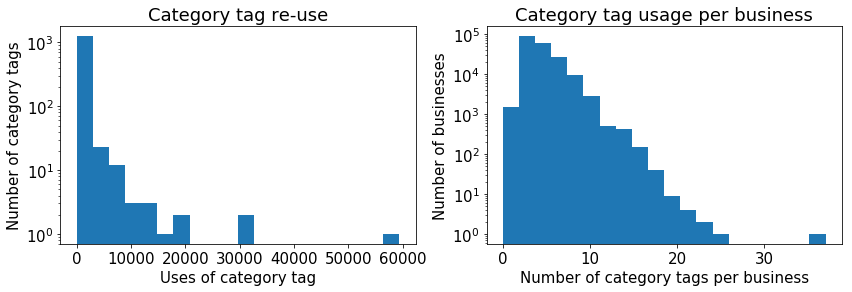

In [12]:
# Plot category tag usage

_ = plt.figure(figsize = (14,4))

_ = plt.subplot(1,2,1)
_ = plt.hist(category_counts.values(), bins = 20)
_ = plt.xlabel('Uses of category tag')
_ = plt.ylabel('Number of category tags')
_ = plt.title('Category tag re-use')
_ = plt.yscale('log')

_ = plt.subplot(1,2,2)
_ = plt.hist(businesses_df.n_categories, bins = 20)
_ = plt.xlabel('Number of category tags per business')
_ = plt.ylabel('Number of businesses')
_ = plt.title('Category tag usage per business')
_ = plt.yscale('log')

In [13]:
# Explore business with high numbers of tags
businesses_df.sort_values('n_categories', ascending = False).head()

,business_id,name,city,latitude,longitude,categories,n_categories
61991,IjsLANGkmAqCsF6-zgIA8w,Best Of The Best DJ's,Las Vegas,36.055128,-115.242644,"[Event Planning & Services, Fashion, Food Cour...",37
20009,Bycp8yesThf7LOBPmBkLpQ,Arrowhead Psychic,Glendale,33.640592,-112.229786,"[Pizza, Home Services, Adult Entertainment, Re...",25
11956,QSwpHbPjDhWYKP8qlmlkXg,Vegas All Nite,Las Vegas,36.128561,-115.171130,"[Nightlife, Tours, Shopping, Hotels, Airport S...",24
159682,uvPv-iPbOtp0Zhgzwn0A3w,Memorial Union,Madison,43.076260,-89.400004,"[Lakes, German, Colleges & Universities, Mexic...",23
73383,tp-kxTZx1ogZm4oNu6d-gQ,Jesse James Body Wellness,Phoenix,33.480900,-111.945030,"[Active Life, Reflexology, Medical Spas, Food,...",22


Problem: how to categorize businesses

Idea: manually annotate tags that are used frequently.  Assign business binary for each tag.
When categories seem contradictory, vote?  Or overrule?

In [14]:
# Now examine reviews
review_ids   = []
business_ids = []
user_ids     = []
dates        = []
starss       = []
with open(review_file, 'r', encoding="latin-1") as f:
    for idx, line in enumerate(f):
        review = json.loads(line)
        #if idx % 10000 == 0:
        #    #Make sure I can see it's working
        #    print('Reading review number %8d' %idx)
        review_ids.append(review['review_id'])
        business_ids.append(review['business_id'])
        user_ids.append(review['user_id'])
        # As of 2019-11-05, the documentation says the date format is '%Y-%m-%d', but this download has '%Y-%m-%d %H:%M:%S'
        dates.append(datetime.strptime(review['date'], '%Y-%m-%d %H:%M:%S'))
        starss.append(review['stars'])
reviews_df = pd.DataFrame({'review_id': review_ids, 'business_id': business_ids, 
                         'user_id': user_ids, 'date': dates, 'stars': starss})

del review_ids
del business_ids
del user_ids
del starss
reviews_df.head()

,review_id,business_id,user_id,date,stars
0,Q1sbwvVQXV2734tPgoKj4Q,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,2013-05-07 04:34:36,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,2017-01-14 21:30:33,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,2016-11-09 20:09:03,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,dacAIZ6fTM6mqwW5uxkskg,2018-01-09 20:56:38,5.0
4,11a8sVPMUFtaC7_ABRkmtw,b1b1eb3uo-w561D0ZfCEiQ,ssoyf2_x0EQMed6fgHeMyQ,2018-01-30 23:07:38,1.0


In [15]:
print('Size of reviews_df: %.2f MB'  % (sys.getsizeof(reviews_df)/1024/1024))

n_reviews = len(reviews_df)
print('Total number of reviews: %d' % n_reviews)

Size of reviews_df: 1613.17 MB
Total number of reviews: 6685900


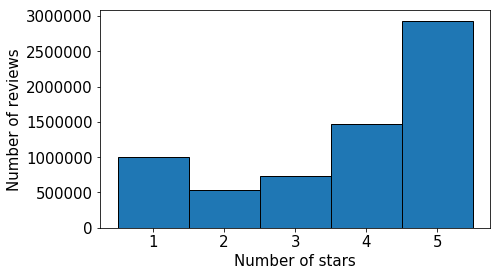

In [16]:
# Visualize distribution of review stars
_ = plt.figure(figsize = (7,4))
_ = plt.hist(reviews_df.stars, bins = [0.5,1.5,2.5,3.5,4.5,5.5], edgecolor = 'k')
_ = plt.xlabel('Number of stars')
_ = plt.ylabel('Number of reviews')
_ = plt.xticks([1,2,3,4,5])

In [17]:
# Merge DataFrames to associate reviews with businesses and users
reviews_annotated = reviews_df.merge(businesses_df, how = 'inner', on = 'business_id')
reviews_annotated = reviews_annotated.merge(users_df, how = 'inner', on = 'user_id')
reviews_annotated.head(10)

,review_id,business_id,user_id,date,stars,name,city,latitude,longitude,categories,n_categories,review_count
0,Q1sbwvVQXV2734tPgoKj4Q,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,2013-05-07 04:34:36,1.0,MountainView Hospital,Las Vegas,36.215546,-115.248798,"[Fitness & Instruction, Doctors, Health & Medi...",8,10
1,oy8f3bxyl7zZJFDQ5edtIA,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,2013-03-27 14:17:13,1.0,MountainView Hospital,Las Vegas,36.215546,-115.248798,"[Fitness & Instruction, Doctors, Health & Medi...",8,10
2,nsr-0uYDWv22qFdARRa2CQ,lsAe6PMRTVGtaBqw3zKlMQ,hG7b0MtEbXx5QzbzE6C_VA,2013-04-24 09:04:10,2.0,Walmart Supercenter,North Las Vegas,36.201056,-115.191736,"[Discount Store, Food, Drugstores, Electronics...",9,10
3,D4_FpPSPRNtAj1964vXFPQ,xpEq8x5caXFm2lmjQ51rVQ,hG7b0MtEbXx5QzbzE6C_VA,2014-02-27 04:20:15,2.0,KLAS-TV,Las Vegas,36.130689,-115.161787,"[Television Stations, Mass Media]",2,10
4,HeTRGukwBk1TPoX0dr4xZA,Y07qIurPKiUJDnTZWxZN2A,hG7b0MtEbXx5QzbzE6C_VA,2012-08-28 23:34:11,5.0,Bistro Buffet,Las Vegas,36.115137,-115.195433,"[Hotels & Travel, Hotels, Restaurants, Italian...",9,10
5,jG7KL6B0n2gY6d_Gy4nGiQ,ucD4zt7QcZ-VspmdKS6PVw,hG7b0MtEbXx5QzbzE6C_VA,2013-04-24 08:43:51,5.0,Autozone,Las Vegas,36.188820,-115.207720,"[Automotive, Auto Parts & Supplies]",2,10
6,C_25_cKO3JXflunMIwBHdA,eSLwC2iFJOU4UWXyuPiTpg,hG7b0MtEbXx5QzbzE6C_VA,2008-08-23 20:07:25,1.0,Hennessey's Tavern,Las Vegas,36.168918,-115.141593,"[Pubs, Bars, Irish Pub, Nightlife, Restaurants...",6,10
7,OJlgpJcV0At_Almwmlf3ow,foPp-aKIZsWcsYf5zuhcNw,hG7b0MtEbXx5QzbzE6C_VA,2016-08-11 03:38:43,1.0,Smith's Food and Drug,Las Vegas,36.186616,-115.225117,"[Grocery, Food]",2,10
8,tDpkjj18ZnumFUa91M34eA,0giQuOv-hLFlVuwgw_VG9A,hG7b0MtEbXx5QzbzE6C_VA,2014-12-11 03:51:29,2.0,Fresh & Easy,Las Vegas,36.215642,-115.226368,"[Florists, Grocery, Shopping, Convenience Stor...",6,10
9,alTTRUEPKEYf_VwqULWnBw,hi85yAQhKmiNmwm_jzkCRA,hG7b0MtEbXx5QzbzE6C_VA,2013-05-07 04:31:06,1.0,One Hour Electric,Las Vegas,36.209377,-115.227070,"[Home Services, Contractors, Electricians]",3,10


In [60]:
cities = {'LA':           (34.052235, -118.243683),
          'SF':           (37.733795, -122.446747),
          'NYC':          (40.730610,  -73.935242), 
          'Chicago':      (41.881832,  -87.623177),
          'Boston':       (42.361145,  -71.057083),
          'Miami':        (25.761681,  -80.191788),
          'Philly':       (39.952583,  -75.165222),
          'Houston':      (29.749907,  -95.358421),
          'DC':           (38.904722,  -77.016389),
          'Atlanta':      (33.748889,  -84.388056),
          'Phoenix':      (33.5722,   -112.0901  ),
          'San Diego':    (32.8153,   -117.135   ),
          'Seattle':      (47.6205,   -122.3509  ),
          #'Indianapolis': (39.76838,   -86.15804 ),
          #'Columbus':     (39.96118,   -82.99879 ),
          'Nashville':    (36.1658333, -86.784444),
          'Denver':       (39.7392358,-104.990251),
          'Las Vegas':    (36.17497,  -115.13722 ),
          'Toronto':      (43.666667,  -79.416667),
          #'Scottsdale':   (33.5091667,-111.8983333),
          'Charlotte':    (35.22709,   -80.84313 ),          
          'Pittsburgh':   (40.4405556, -79.9961111),          
          #'Henderson':    (36.0397222,-114.9811111),           
          #'Tempe':        (33.4147222,-111.9086111),               
          #'Mesa':         (33.4222222,-111.8219444),                
          #'Chandler':     (33.3061111,-111.8405556),
          'Montreal':     (45.5,       -73.583333),
          #'Gilbert':      (33.3527778,-111.7883333),             
          'Cleveland':    (41.4994444, -81.6955556),           
          'Madison':      (43.0730556, -89.4011111),             
          #'Glendale':     (),            
          'Calgary':      (51.083333, -114.083333),              
          #'Peoria, IL':   (40.6936111, -89.5888889)
          #'Peoria, AZ':   (33.5805556,-112.2366667)
          'Champaign':    (40.1163889, -88.2433333)
         }
top_cities_names = ['Las Vegas', 'Phoenix', 'Charlotte', 'Toronto', 'Cleveland', 
                    'Pittsburgh', 'Madison', 'Montreal', 'Calgary', 'Champaign']
top_cities = {name: cities[name] for name in top_cities_names}

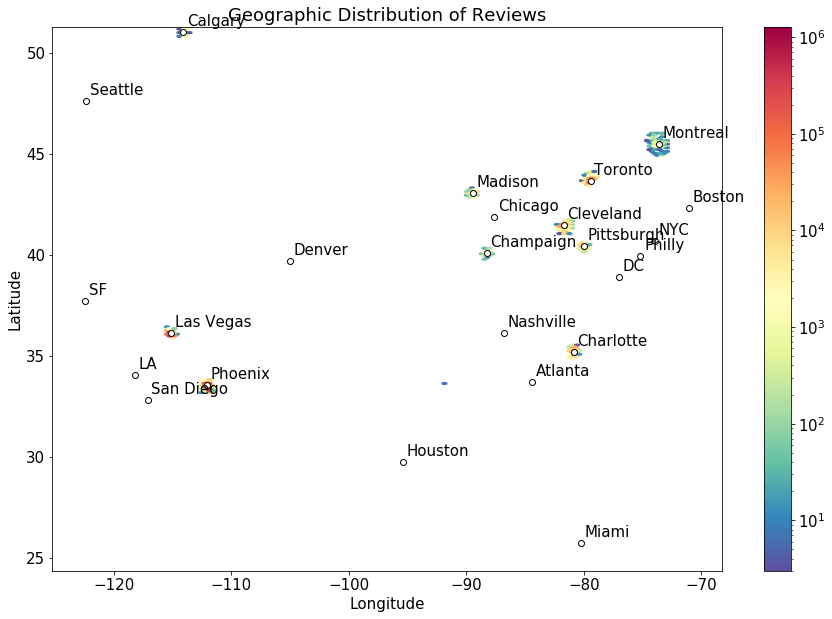

In [61]:
# Visualize latitude and longitude of all reviews - it should be possible to see locations of major cities!
_ = plt.figure(figsize = (15,10))
_ = plt.hexbin(reviews_annotated.longitude, reviews_annotated.latitude, gridsize = (100,100), bins = 'log', mincnt = 1)
_ = plt.colorbar()
for city, xy in cities.items():
    plt.scatter(xy[1], xy[0], marker = 'o', edgecolor = 'k', c = 'w')
    plt.text(xy[1]+0.3, xy[0]+0.3, city)
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Geographic Distribution of Reviews')
_ = plt.savefig('ReviewGeography.png')

In [29]:
reviews_annotated.groupby('city').count().review_id.sort_values(ascending = False).head(30)

city
Las Vegas          2030798
Phoenix             734136
Toronto             525437
Scottsdale          387550
Charlotte           309425
Pittsburgh          225496
Henderson           219880
Tempe               202074
Mesa                168311
Chandler            157581
MontrÃ©al           151238
Gilbert             129057
Cleveland           114389
Madison             104637
Glendale            100303
Calgary              97650
Peoria               57857
Mississauga          55585
Markham              51296
North Las Vegas      50954
Surprise             34888
Champaign            30904
Goodyear             28596
Richmond Hill        24245
Avondale             22144
North York           20358
Scarborough          19115
Concord              18619
Lakewood             18212
Vaughan              16126
Name: review_id, dtype: int64

Turns out this is a geographically weird collection of reviews.  Most are from Las Vegas and Phoenix (and nearby cities), with many in Charlotte, Toronto, Cleveland, Pittsburgh, Madison, Montreal, Calgary, and Champaign.

Is this selected by business or by user?  If the former, then I won't be able to see a user's "away" reviews.

In [36]:
businesses_df.groupby('city').count().business_id.sort_values(ascending = False).head(30)

city
Las Vegas          29370
Toronto            18906
Phoenix            18766
Charlotte           9509
Scottsdale          8837
Calgary             7736
Pittsburgh          7017
MontrÃ©al           6449
Mesa                6080
Henderson           4892
Tempe               4550
Chandler            4309
Cleveland           3605
Glendale            3543
Madison             3494
Gilbert             3462
Mississauga         3112
Peoria              1919
Markham             1766
North Las Vegas     1548
Champaign           1262
North York          1205
Surprise            1148
Scarborough         1103
Richmond Hill       1026
Brampton            1002
Concord              990
Vaughan              919
Goodyear             855
Etobicoke            793
Name: business_id, dtype: int64

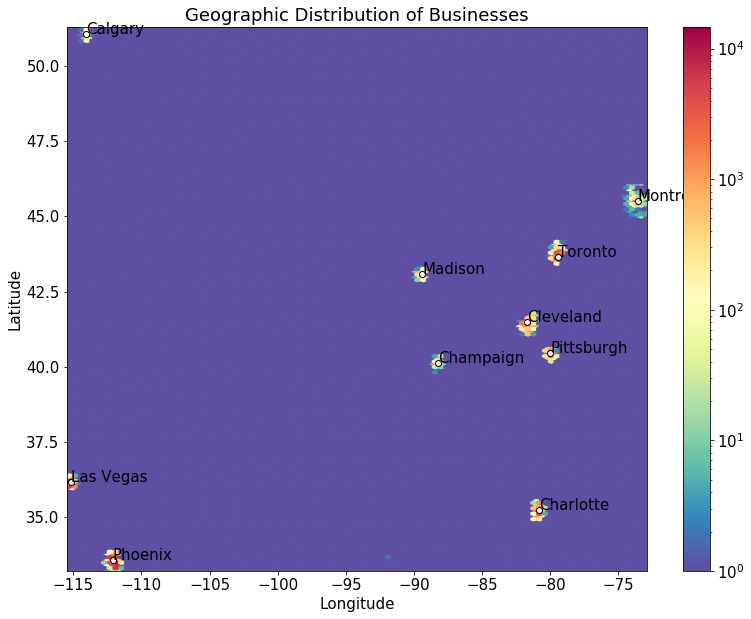

In [52]:
# Visualize latitude and longitude of all businesses
_ = plt.figure(figsize = (13,10))
_ = plt.hexbin(businesses_df.longitude, businesses_df.latitude, gridsize = (100,100), bins = 'log')
_ = plt.colorbar()
for city, xy in top_cities.items():
    plt.scatter(xy[1], xy[0], marker = 'o', edgecolor = 'k', c = 'w')
    plt.text(xy[1], xy[0], city)
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')
_ = plt.title('Geographic Distribution of Businesses')

<Figure size 432x288 with 0 Axes>

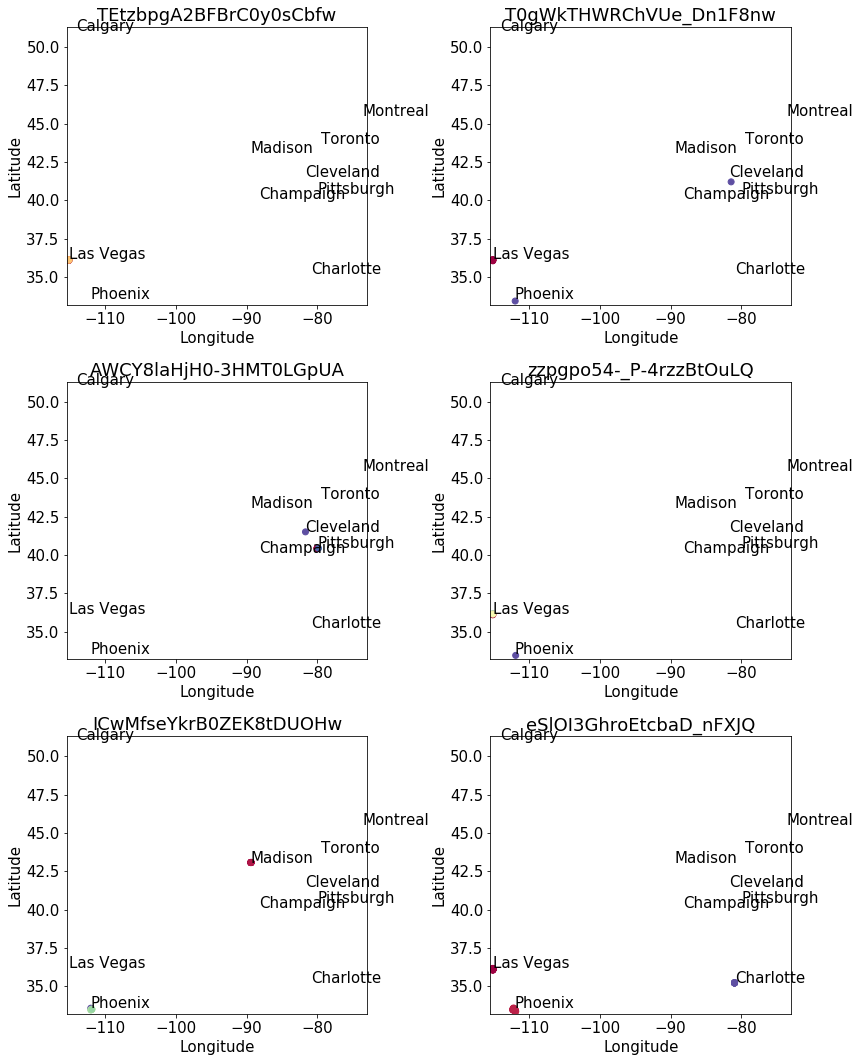

In [46]:
# Visualize distributions of reviews from a few users, with density mapping due to overlapping points
longitude_range = [min(businesses_df.longitude), max(businesses_df.longitude)]
latitude_range  = [min(businesses_df.latitude ), max(businesses_df.latitude )]

superusers = users_df[users_df.review_count >= 500]
plt.set_cmap('Spectral_r')
_ = plt.figure(figsize = (12,15))
for idx in range(6):
    user_id = superusers.user_id.iloc[idx]
    reviews_subset = reviews_annotated.loc[reviews_annotated.user_id == user_id]
    x = reviews_subset.longitude
    y = reviews_subset.latitude
    xy = np.vstack([x,y])
    density = gaussian_kde(xy)(xy)
    _ = plt.subplot(3,2,idx+1)
    for city, xy in top_cities.items():
        #plt.scatter(xy[1], xy[0], marker = 'o', edgecolor = 'k', c = 'w')
        plt.text(xy[1], xy[0], city)
    _ = plt.scatter(x,y, c=density)
    _ = plt.xlabel('Longitude')
    _ = plt.ylabel('Latitude')
    _ = plt.xlim(longitude_range)
    _ = plt.ylim(latitude_range)
    _ = plt.title(user_id)
_ = plt.tight_layout()

Because the data is so geographically restricted, it looks like I may not be able to do the home/away comparison.